In [ ]:
# Install required packages
!pip install -q transformers datasets sentencepiece
!pip install -q pytorch-lightning wandb
!pip install -q donut-python

# !huggingface-cli login this shouldh be done from the terminal

In [25]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("Jac-Zac/thesis_test_donut", revision = 'c13aef46a13c2646b315bf37bb6bfa38033a48db')
model = VisionEncoderDecoderModel.from_pretrained("Jac-Zac/thesis_test_donut", revision = 'c13aef46a13c2646b315bf37bb6bfa38033a48db')

In [ ]:
import re
import json
import torch
from tqdm.auto import tqdm
import numpy as np
import random
from PIL import Image

from donut import JSONParseEvaluator
from datasets import load_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

model.eval()
model.to(device)

output_list = []
accs = []

image_path = "/Users/jaczac/Github/Thesis/donut_example/small_copy/img_resized"

dataset = load_dataset(image_path, split="test")


for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_herbarium>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device)
    
    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = json.loads(sample["ground_truth"])
    
    # modify ground_truth to replace " " with "" since I would still count it as a correct prediction
    ground_truth = json.loads(sample["ground_truth"].replace('" "', '""'))
    
    evaluator = JSONParseEvaluator()
    score = evaluator.cal_acc(seq, ground_truth)

    accs.append(score)
    output_list.append(seq)

scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")

Resolving data files:   0%|          | 0/1553 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/138 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/139 [00:00<?, ?it/s]

Found cached dataset imagefolder (/Users/jaczac/.cache/huggingface/datasets/imagefolder/img_resized-7f5590504a871c24/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/138 [00:00<?, ?it/s]

In [ ]:
print("Mean accuracy:", np.mean(accs))

In [ ]:
print("Mean accuracy:", np.median(accs))

Ground Truth: {"Nome_verbatim": "Athyrium sp\n", "Nome_floritaly": " ", "Luogo_Raccolta": "Monte Paularo", "Altitudine": 1800, "Giorno": 19, "Mese": 8.0, "Anno": 1971.0}

Prediction: {'Nome_verbatim': 'Athyrium filix-femina (L.) Roth', 'Nome_floritaly': 'Athyrium filix-femina (L.) Roth', 'Luogo_Raccolta': 'Monte Paularo', 'Altitudine': '1800', 'Giorno': '19', 'Mese': '8.0', 'Anno': '1971.0'}

Score: 0



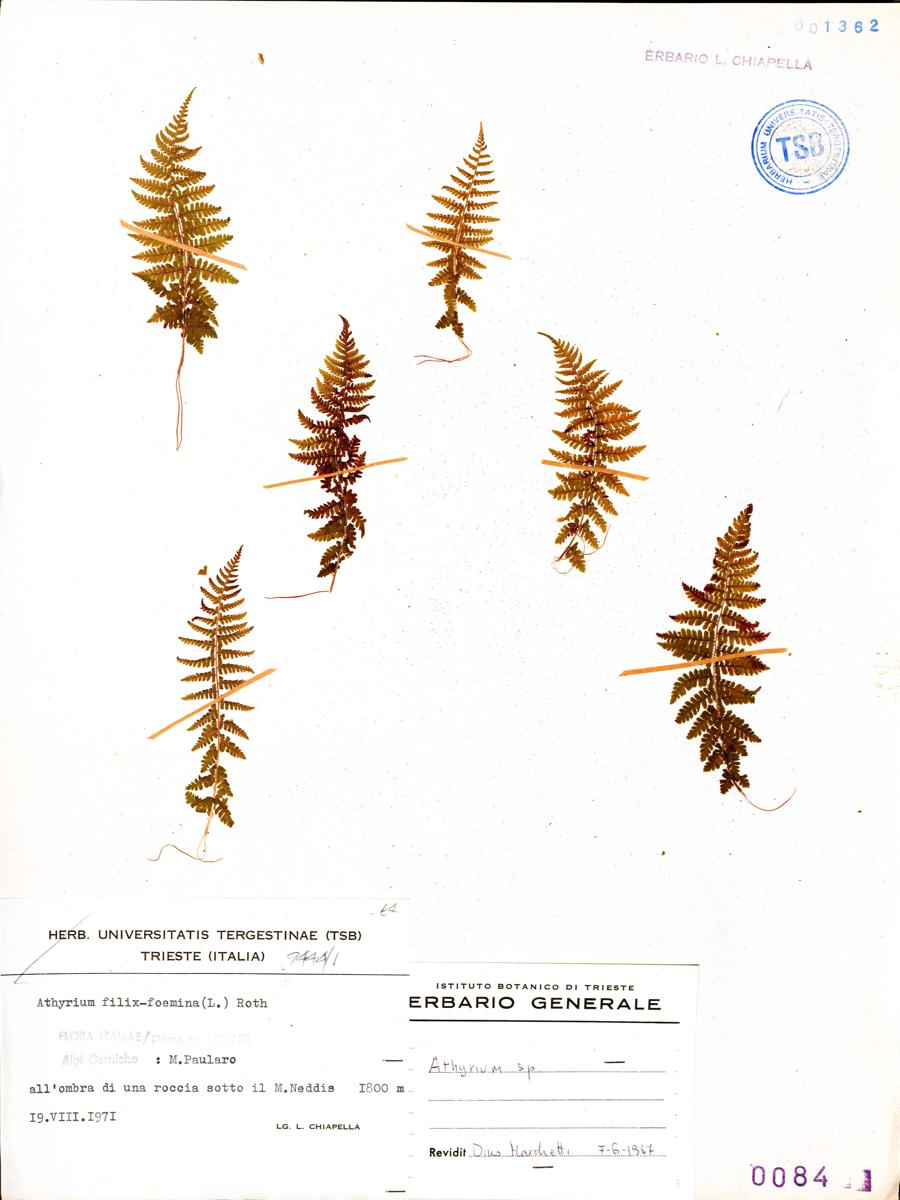

Ground Truth: {"Nome_verbatim": "Asplenium ", "Nome_floritaly": " ", "Luogo_Raccolta": "Tempio Pausania", "Altitudine": 500, "Giorno": 9, "Mese": 5.0, "Anno": 1971.0}

Prediction: {'Nome_verbatim': 'Asplenium fontanum (L.) Bernh ex Desv', 'Nome_floritaly': 'Asplenium fontanum (L.) Bernh. subsp. fontanum', 'Luogo_Raccolta': '', 'Altitudine': '500', 'Giorno': '4', 'Mese': '6.0', 'Anno': '1971.0'}

Score: 0



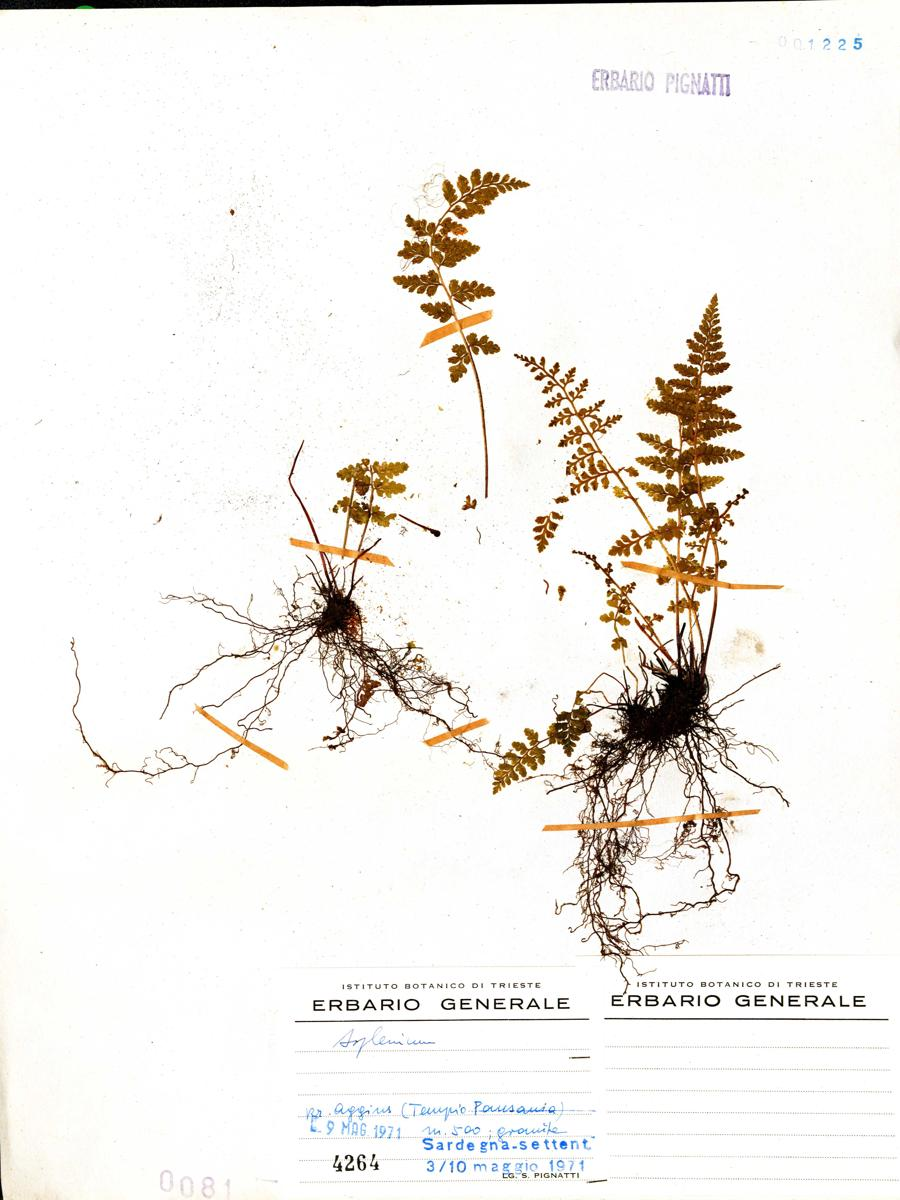

Ground Truth: {"Nome_verbatim": "Polypodium vulgare L\n", "Nome_floritaly": "Polypodium vulgare L.", "Luogo_Raccolta": "A\u00efn Draham", "Altitudine": " ", "Giorno": 17, "Mese": 6.0, "Anno": 1951.0}

Prediction: {'Nome_verbatim': 'Dryopteris montana (Lam.) Reich ex setatum (W.) Sching', 'Nome_floritaly': 'Dryopteris montana (Lam.) Bernh. ex Schrank & Mart. subsp. hastatum (C.) Newman', 'Luogo_Raccolta': 'Monte Puricis', 'Altitudine': '', 'Giorno': '17', 'Mese': '6.0', 'Anno': '1951.0'}

Score: 0



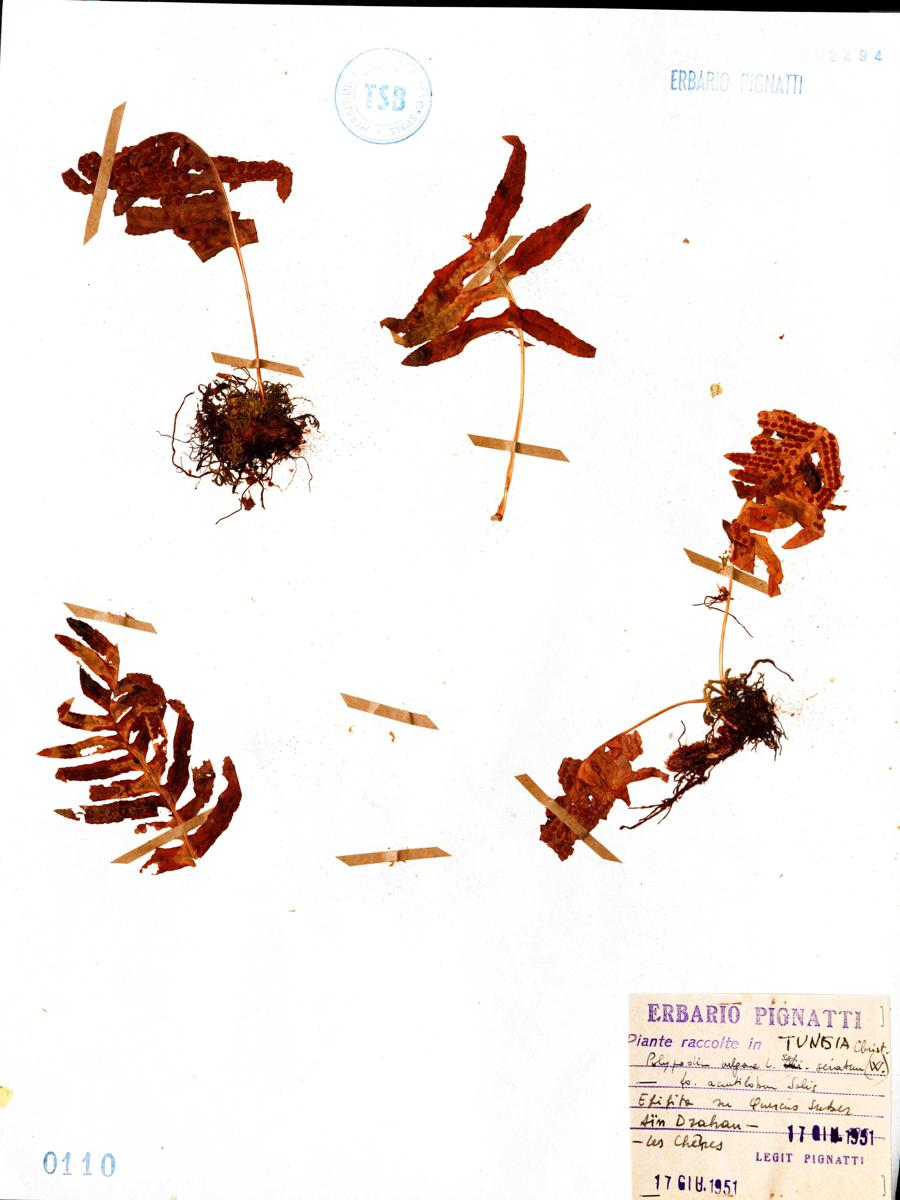

Ground Truth: {"Nome_verbatim": "Athyrium sp\n", "Nome_floritaly": " ", "Luogo_Raccolta": "Monte Paularo", "Altitudine": 1400, "Giorno": 19, "Mese": 8.0, "Anno": 1971.0}

Prediction: {'Nome_verbatim': 'Athyrium filix-femina (L.) Roth', 'Nome_floritaly': 'Athyrium filix-femina (L.) Roth', 'Luogo_Raccolta': 'Monte Paularo', 'Altitudine': '1400', 'Giorno': '19', 'Mese': '8.0', 'Anno': '1971.0'}

Score: 0



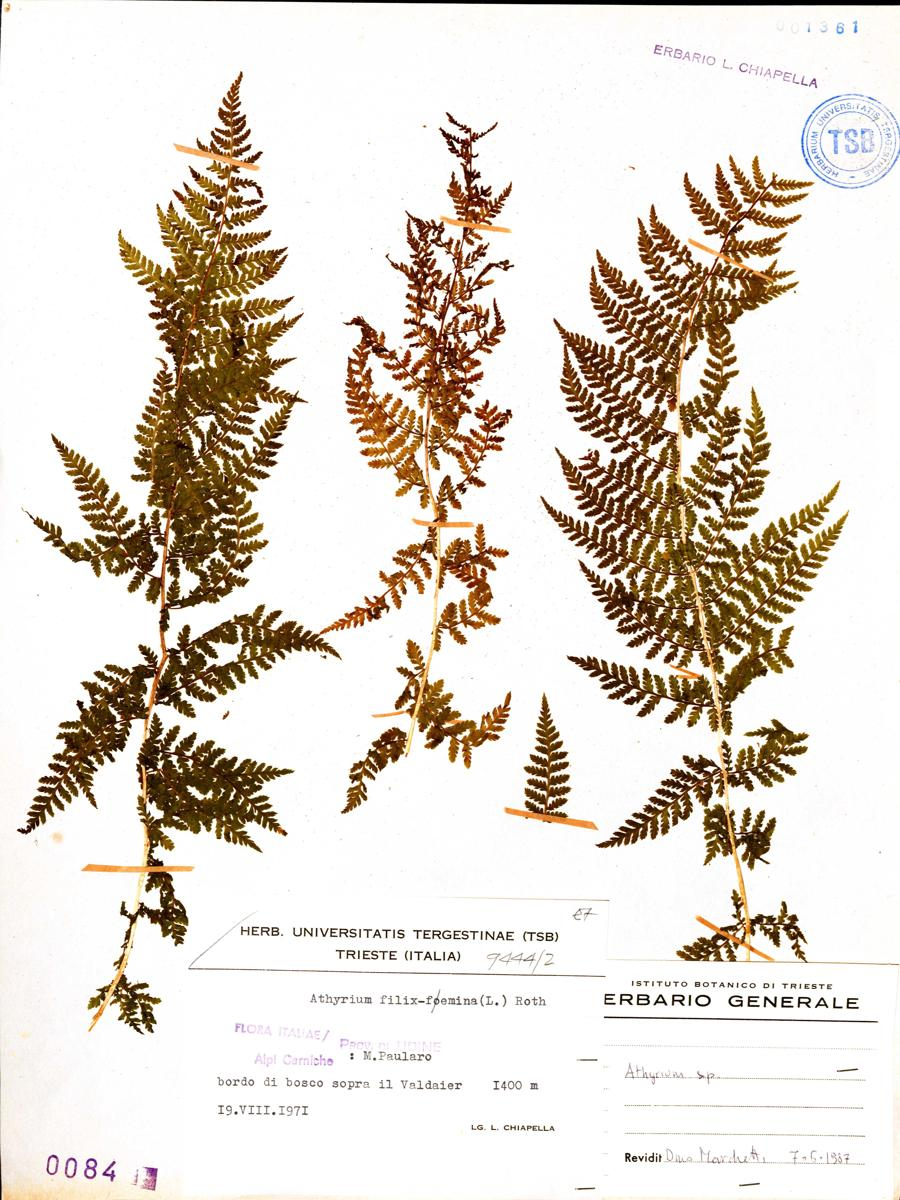

Ground Truth: {"Nome_verbatim": "Stegnogramma pozoi (Lag.) Iwatsuki", "Nome_floritaly": "Stegnogramma pozoi (Lag.) K.Iwats", "Luogo_Raccolta": "Aia, Comune in Spagna", "Altitudine": 180, "Giorno": 1, "Mese": 9.0, "Anno": 1984.0}

Prediction: {'Nome_verbatim': 'Lycopodium (L.) New', 'Nome_floritaly': 'Huperzia selago (L.) Bernh. ex Schrank & Mart. subsp. selago', 'Luogo_Raccolta': 'Riserva naturale Vincheto, Spagna', 'Altitudine': '130', 'Giorno': '30', 'Mese': '7.0', 'Anno': '1984.0'}

Score: 0.07407407407407407



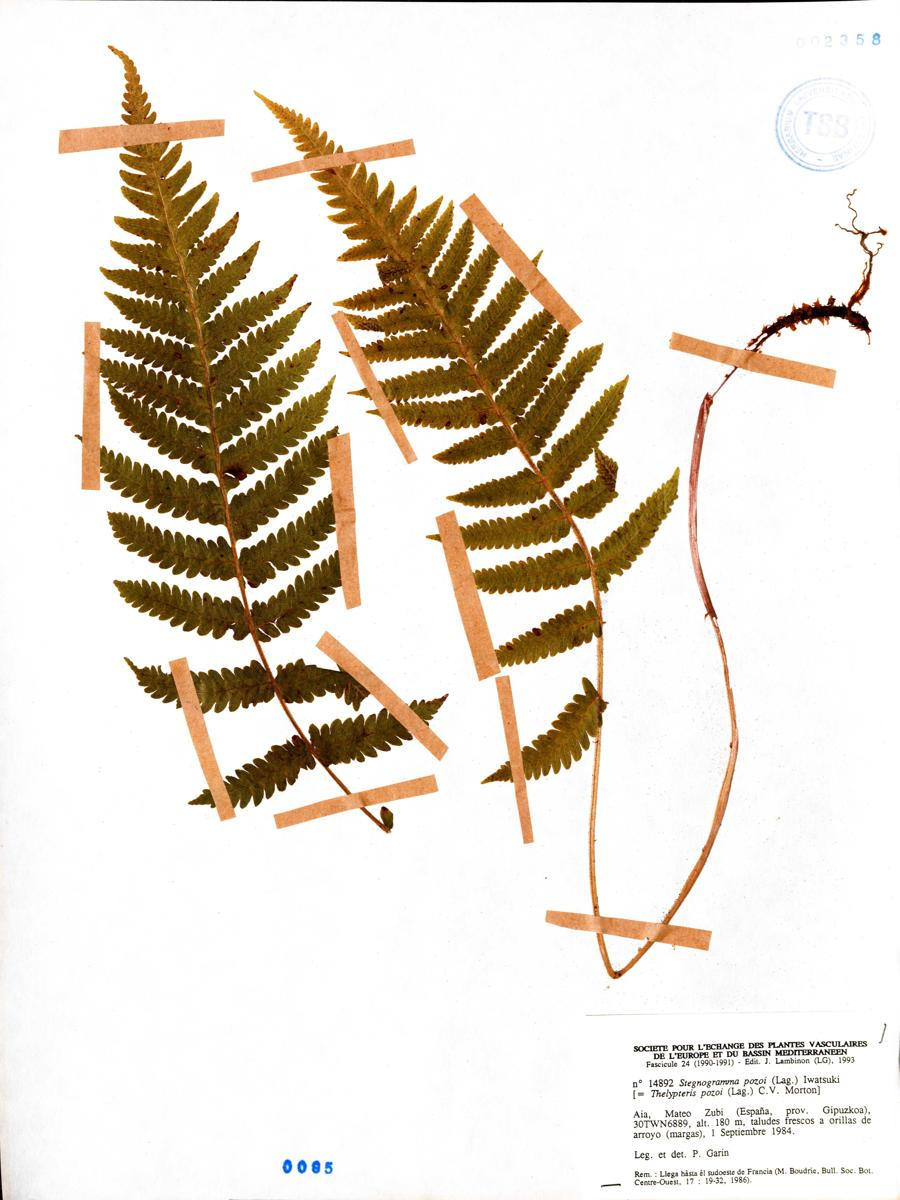

In [24]:
# get indices of worst 5 predictions
worst_idxs = np.argsort(accs)[:5].tolist()

# prepare decoder inputs
task_prompt = "<s_herbarium>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
decoder_input_ids = decoder_input_ids.to(device)

for idx in worst_idxs:
    sample = dataset[idx]

    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)

    # autoregressively generate sequence
    outputs = model.generate(
        pixel_values,
        decoder_input_ids=decoder_input_ids,
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)
    
    print(f"Ground Truth: {sample['ground_truth']}\n")
    print(f"Prediction: {seq}\n")
    print(f"Score: {accs[idx]}\n")
    display(sample["image"])